# Brain Tumor Detection - ResNet50

## ResNet50 Architecture

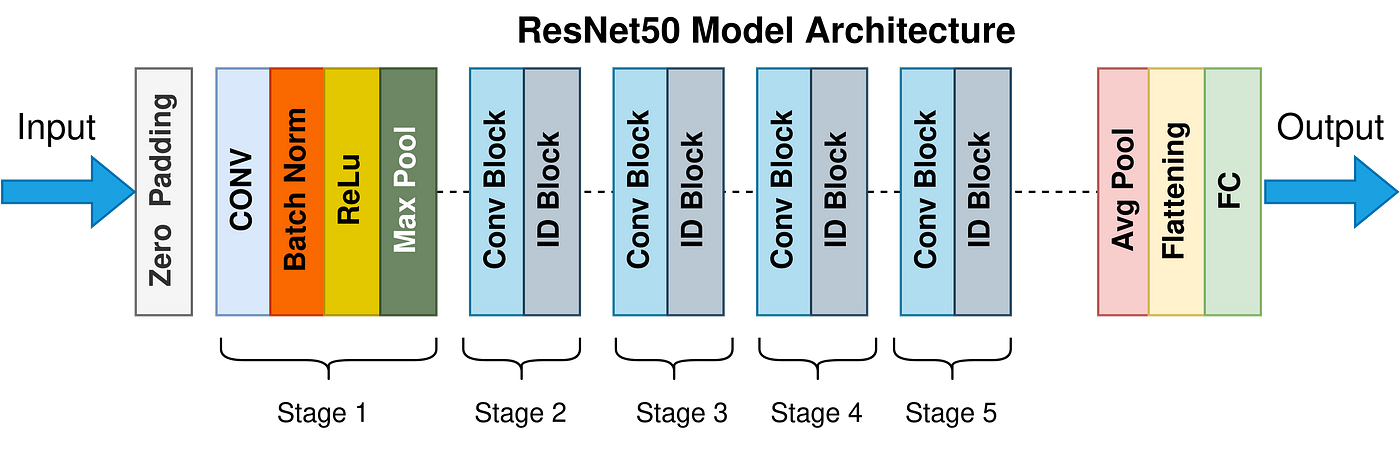

## Import Essential Libraries

In [19]:
# Regular Libraries Imports
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from utils import *
import tensorflow as tf
import keras_tuner as kt
import os
import random
import numpy as np
import cv2
import pandas as pd

# Machine Learning Imports
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt



# Define Constant image size
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
IMAGE_SIZE = (IMG_HEIGHT,IMG_WIDTH)
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)


# 1. Data Exploration

In [2]:
glioma_images = os.listdir(DATASET_FOLDER + "/glioma")
meningioma_images = os.listdir(DATASET_FOLDER + "/meningioma")
no_tumor_images = os.listdir(DATASET_FOLDER + "/notumor")
pituitary_images = os.listdir(DATASET_FOLDER + "/pituitary")

# Check number of images in each category
print(f"Number of images in each category: Glioma: {len(glioma_images)}, Meningioma: {len(meningioma_images)}, No Tumor: {len(no_tumor_images)}, Pituitary: {len(pituitary_images)}")

Number of images in each category: Glioma: 120, Meningioma: 120, No Tumor: 120, Pituitary: 120


*Since there are equal number of data in each class, we can confirm that there will not be any class dominance.*

## Data Sample from each classes

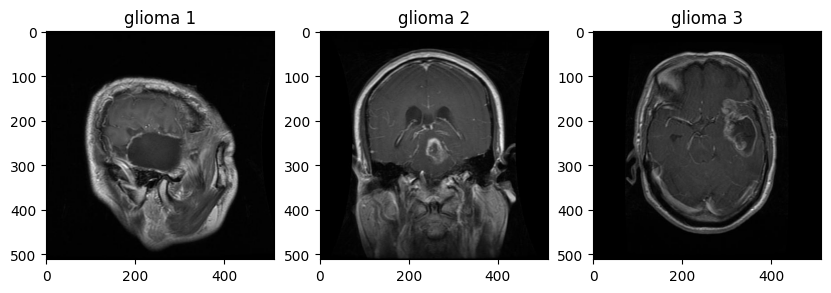

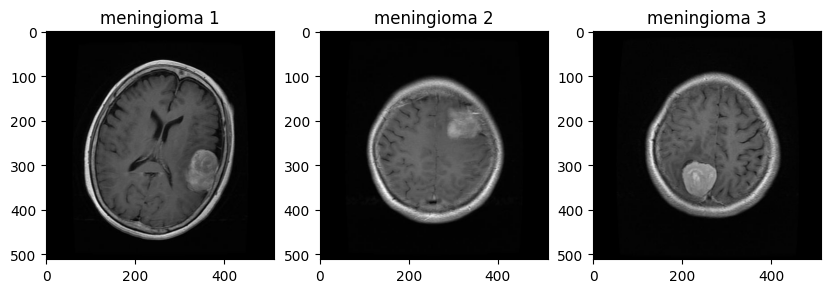

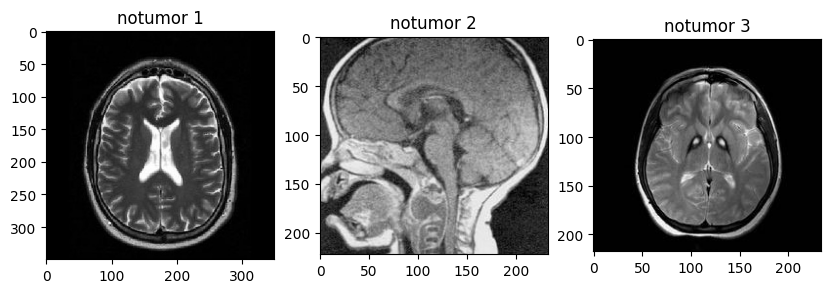

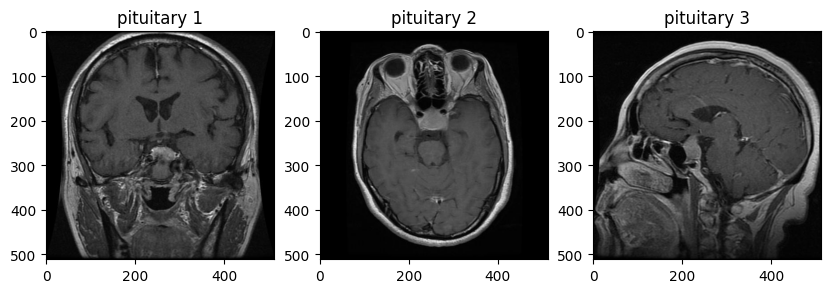

In [3]:
# Function to sample and plot images
def sample_and_plot_images(image_list, category_name, dataset_folder, n=3):
    sampled_images = random.sample(image_list, n)
    plt.figure(figsize=(10, 10))
    for i, img_name in enumerate(sampled_images):
        img_path = os.path.join(dataset_folder, category_name, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{category_name} {i+1}")
    plt.show()

# Sample and plot images for each category
sample_and_plot_images(glioma_images, "glioma", DATASET_FOLDER)
sample_and_plot_images(meningioma_images, "meningioma", DATASET_FOLDER)
sample_and_plot_images(no_tumor_images, "notumor", DATASET_FOLDER)
sample_and_plot_images(pituitary_images, "pituitary", DATASET_FOLDER)

*Based on the output of the sample images, the scale of each image are in differnet scale. Therefore, rescaling operation has to be done because it standardizes the range of pixel values, making the training process more stable and helping the model converge faster.*

# 2. Data Preparation

Found 480 files belonging to 4 classes.
Using 384 files for training.
Using 96 files for validation.
Class Names: ['glioma', 'meningioma', 'notumor', 'pituitary']

Training Dataset Preview


2024-06-18 22:59:12.021896: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-06-18 22:59:12.021921: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-18 22:59:12.021924: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-18 22:59:12.021940: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-18 22:59:12.021951: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-06-18 22:59:12.228924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


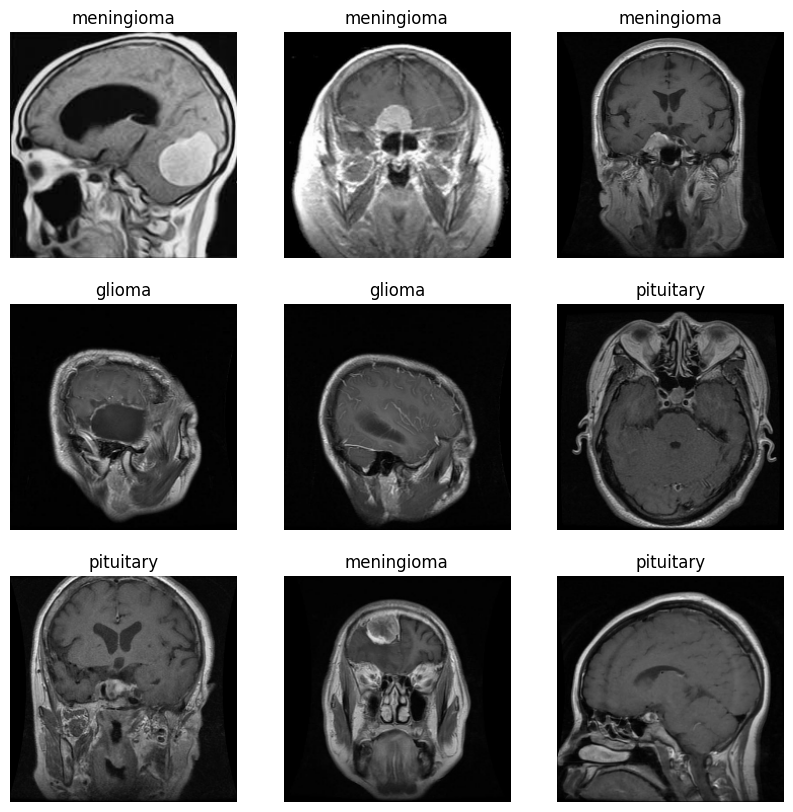

Validation Dataset Preview


2024-06-18 22:59:12.594551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


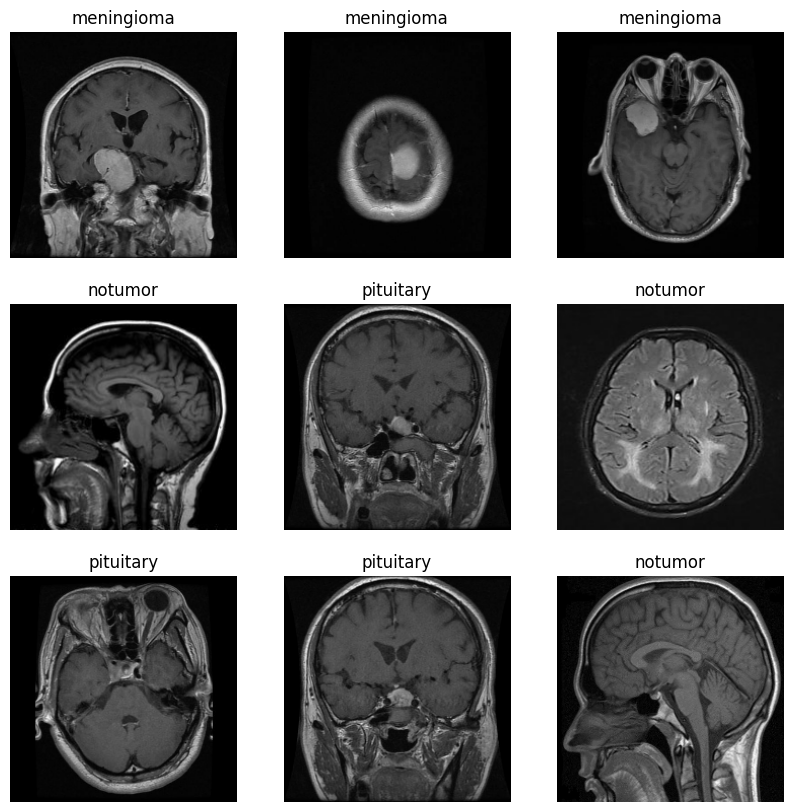

In [4]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_FOLDER,
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    subset = "both",
    validation_split = 0.2,
    seed = 42,
    shuffle = True)

class_names = train_ds.class_names
print("Class Names:" , class_names)

# Preview datasets
print("\nTraining Dataset Preview")
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

print("Validation Dataset Preview")
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 3. Model Building - ResNet50V2
*Improved Version of ResNet50v2*

### 3.1 Finding out the most optimal learning rate

In [6]:
# Load ResNet50V2 base model
base_model = ResNet50V2(include_top=False, input_shape=INPUT_SHAPE)
base_model.trainable = False

model = tf.keras.Sequential(layers=[
    #Data Augmentation
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomZoom(0.05, 0.05),
    tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),
    #Base model and Custom Layer
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation="softmax") # 4 classes to classify
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

epochs = 50
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

history = model.fit(train_ds,
                     epochs=epochs,
                     validation_data=val_ds,
                     callbacks=[lr_scheduler]
                     )

Epoch 1/50


2024-06-18 22:59:15.069959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 454ms/step - accuracy: 0.2834 - loss: 2.1662 - val_accuracy: 0.4479 - val_loss: 1.2064 - learning_rate: 1.0000e-04
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - accuracy: 0.3350 - loss: 1.5823 - val_accuracy: 0.6771 - val_loss: 0.9607 - learning_rate: 1.1220e-04
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - accuracy: 0.5548 - loss: 1.0304 - val_accuracy: 0.7188 - val_loss: 0.8469 - learning_rate: 1.2589e-04
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.5861 - loss: 0.9949 - val_accuracy: 0.7396 - val_loss: 0.7447 - learning_rate: 1.4125e-04
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.6439 - loss: 0.8874 - val_accuracy: 0.7188 - val_loss: 0.6835 - learning_rate: 1.5849e-04
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - accuracy: 0.6776 - loss: 0.7640 - val_accuracy: 0.7292 - val_loss: 0.6176 - learning_rate: 1.7783e-04
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - accuracy: 0.7035 - l

Text(0, 0.5, 'val_loss')

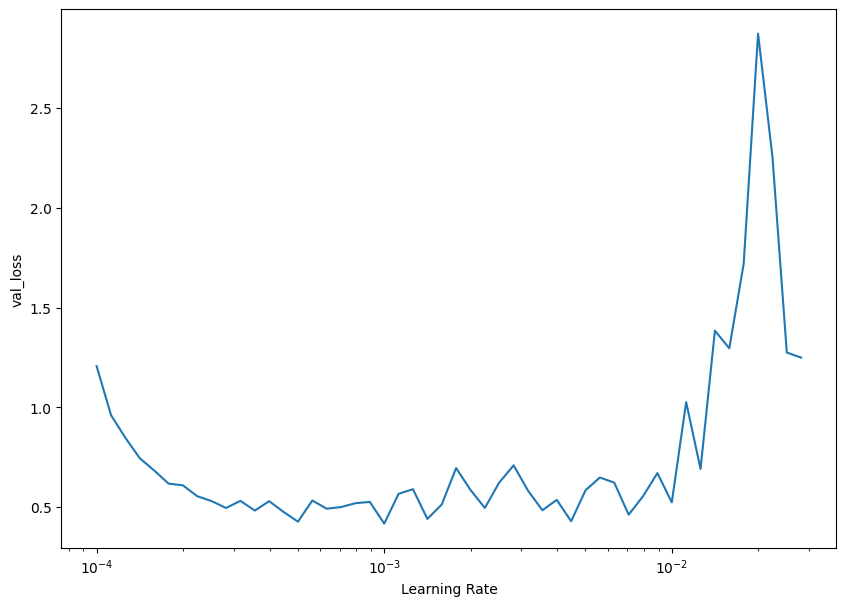

In [7]:
lrs = 1e-4 * (10 ** (np.arange(epochs)/20))
plt.figure(figsize=(10,7))
plt.semilogx(lrs, history.history['val_loss'])
plt.xlabel('Learning Rate')
plt.ylabel('val_loss')

In [8]:
minimum = min(history.history['val_loss'])
index = history.history['val_loss'].index(minimum)
lr = lrs[index]
print("The better learning rate is", lr)

The better learning rate is 0.001


### 3.2 Training the Model with the most optimal learning rate

In [9]:
# Load ResNet50V2 base model
base_model = ResNet50V2(include_top=False, input_shape=INPUT_SHAPE)
base_model.trainable = False

model = tf.keras.Sequential(layers=[
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomZoom(0.05, 0.05),
    tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation="softmax")
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
               metrics=["accuracy"])

epochs = 50

history = model.fit(train_ds,
                     epochs=epochs,
                     validation_data=val_ds
                     )

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 566ms/step - accuracy: 0.4174 - loss: 1.6650 - val_accuracy: 0.6250 - val_loss: 0.7268
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.6508 - loss: 0.9795 - val_accuracy: 0.7292 - val_loss: 0.6133
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.6761 - loss: 0.9567 - val_accuracy: 0.7292 - val_loss: 0.5772
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.7972 - loss: 0.6277 - val_accuracy: 0.7292 - val_loss: 0.6133
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - accuracy: 0.7799 - loss: 0.5590 - val_accuracy: 0.8021 - val_loss: 0.5156
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - accuracy: 0.7600 - loss: 0.5394 - val_accuracy: 0.7917 - val_loss: 0.5218
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.8044 - loss: 0.5325 - val_accuracy: 0.7396 - val_loss: 0.5817
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.7457 - loss: 0.5728 - val_accuracy: 0

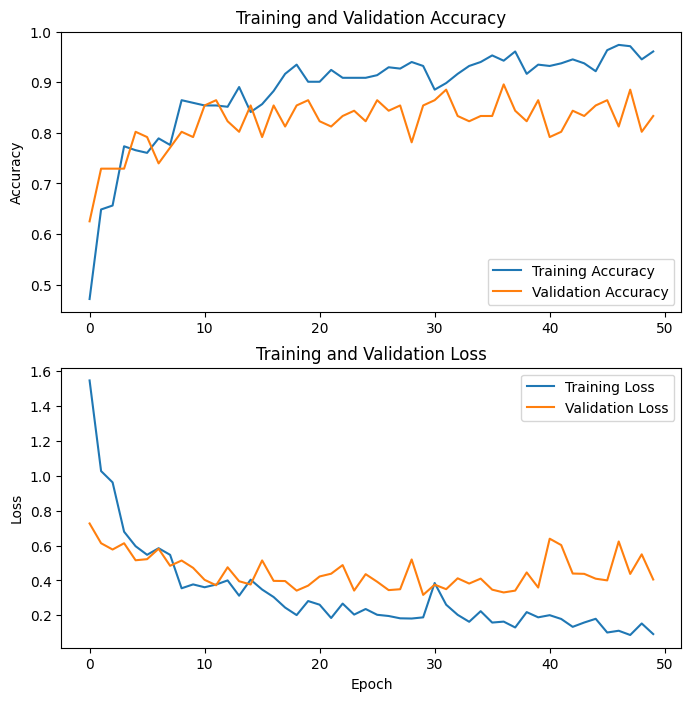

Training Results:
~Accuracy~
Max (best) accuracy: 0.9739583134651184 at epoch 47
Min (worst) accuracy: 0.4713541567325592 at epoch 1
Median accuracy: 0.9153645932674408
Mean accuracy: 0.8822916716337204

~Loss~
Min (best) loss: 0.08655854314565659 at epoch 48
Max (worst) loss: 1.5478516817092896 at epoch 1
Median loss: 0.22056038677692413
Mean loss: 0.320773433893919

~Final Training Performance~
Accuracy: 0.9869791865348816, Loss: 0.05020424723625183

Validation Results:
~Accuracy~
Max (best) accuracy: 0.8958333134651184 at epoch 37
Min (worst) accuracy: 0.625 at epoch 1
Median accuracy: 0.8333333134651184
Mean accuracy: 0.8208333337306977

~Loss~
Min (best) loss: 0.3167816400527954 at epoch 30
Max (worst) loss: 0.7268021702766418 at epoch 1
Median loss: 0.4172886610031128
Mean loss: 0.44814183950424197

~Final Validation Performance~
Accuracy: 0.8333333134651184, Loss: 0.4051322638988495


In [10]:
# Visualise model performance throughout epochs
# Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
# Loss
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

# Get epoch of optimal parameters
print("Training Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history.history['accuracy']), "at epoch", history.history['accuracy'].index(max(history.history['accuracy'])) + 1)
print("Min (worst) accuracy:", min(history.history['accuracy']), "at epoch", history.history['accuracy'].index(min(history.history['accuracy'])) + 1)
print("Median accuracy:", np.median(history.history['accuracy']))
print("Mean accuracy:", np.mean(history.history['accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history.history['loss']), "at epoch", history.history['loss'].index(min(history.history['loss'])) + 1)
print("Max (worst) loss:", max(history.history['loss']), "at epoch", history.history['loss'].index(max(history.history['loss'])) + 1)
print("Median loss:", np.median(history.history['loss']))
print("Mean loss:", np.mean(history.history['loss']))

print("\n~Final Training Performance~")
print("Accuracy: {1}, Loss: {0}".format(*model.evaluate(train_ds, verbose=0)))

print("\nValidation Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history.history['val_accuracy']), "at epoch", history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1)
print("Min (worst) accuracy:", min(history.history['val_accuracy']), "at epoch", history.history['val_accuracy'].index(min(history.history['val_accuracy'])) + 1)
print("Median accuracy:", np.median(history.history['val_accuracy']))
print("Mean accuracy:", np.mean(history.history['val_accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history.history['val_loss']), "at epoch", history.history['val_loss'].index(min(history.history['val_loss'])) + 1)
print("Max (worst) loss:", max(history.history['val_loss']), "at epoch", history.history['val_loss'].index(max(history.history['val_loss'])) + 1)
print("Median loss:", np.median(history.history['val_loss']))
print("Mean loss:", np.mean(history.history['val_loss']))

print("\n~Final Validation Performance~")
print("Accuracy: {1}, Loss: {0}".format(*model.evaluate(val_ds, verbose=0)))

2024-06-18 23:03:52.433724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


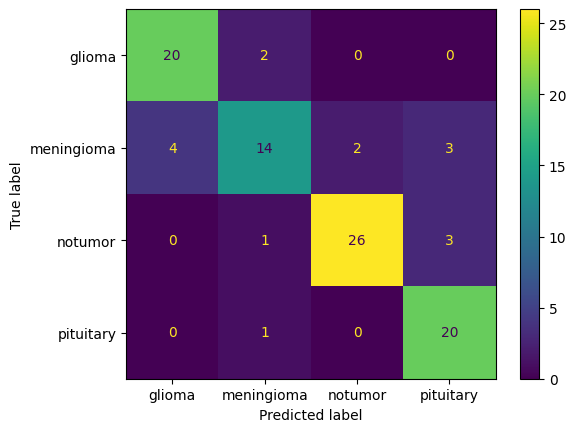

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = []
y_true = []
y_pred = []

predictions = model.predict(val_ds, verbose=0)
for prediction in predictions:
    score = tf.nn.softmax(prediction)
    y_pred.append(np.argmax(score))
    
for X, y in val_ds.as_numpy_iterator():  
    y_true.extend(y)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot()

In [12]:
def metrics2dt(acc, rc, pr, f1):
    return pd.DataFrame(data={"Accuracy":acc, "Recall":rc, "Precision":pr, "F1-Score":f1}, index=[0])

def show_metrics(y_true, y_pred):
    recall = tf.keras.metrics.Recall()
    precision = tf.keras.metrics.Precision()
    accuracy = tf.keras.metrics.Accuracy()

    recall.update_state(y_true, y_pred)
    recall = recall.result().numpy()
    
    precision.update_state(y_true, y_pred)
    precision = precision.result().numpy()
    
    accuracy.update_state(y_true, y_pred)
    accuracy = accuracy.result().numpy()
    
    f1_score = 0
    if recall+precision != 0:
        f1_score = 2 * ((recall*precision)/(recall+precision))
    
    return metrics2dt(accuracy, recall, precision, f1_score)

validation_metrics = show_metrics(y_true,y_pred)
validation_metrics

,Accuracy,Recall,Precision,F1-Score
0,0.833333,0.945946,0.972222,0.958904


### K-Fold Cross-Validation - v1 

In [14]:
from sklearn.model_selection import StratifiedKFold, KFold

""" K-Fold Cross-Validation """
# Load dataset without validation split
dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_FOLDER,
    shuffle=True,
    seed=RANDOM_STATE,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Convert dataset to numpy arrays for k-fold splitting
images = []
labels = []
for image, label in dataset:
    images.append(image.numpy())
    labels.append(label.numpy())
images = np.concatenate(images)
labels = np.concatenate(labels)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Initialise lists to store results
list_kf_results = []
list_skf_results = []

print("K-Fold Cross-Validation")
fold_no = 0
for train_index, val_index in kf.split(images):
    # Split data
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]
    
    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

    # Prefetch datasets
    train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

    # Train the model
    history = model.fit(train_ds, validation_data=val_ds, epochs=50, batch_size=64, verbose=0)
    
    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(train_ds, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
    
    # Save results
    list_kf_results.append({"train_loss": train_loss, "train_accuracy": train_accuracy, "val_loss": val_loss, "val_accuracy": val_accuracy, "history": history})
    
    print("Fold Index", fold_no)
    print("~Training Dataset~\nAccuracy: {}, Loss: {}".format(train_accuracy, train_loss))
    print("~Validation Dataset~\nAccuracy: {}, Loss: {}".format(val_accuracy, val_loss), end="\n\n")
    
    # Increment fold number
    fold_no += 1

Found 480 files belonging to 4 classes.


2024-06-18 23:05:30.332857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


K-Fold Cross-Validation
Fold Index 0
~Training Dataset~
Accuracy: 0.9791666865348816, Loss: 0.06915464252233505
~Validation Dataset~
Accuracy: 0.875, Loss: 0.43724608421325684

Fold Index 1
~Training Dataset~
Accuracy: 0.984375, Loss: 0.0524594746530056
~Validation Dataset~
Accuracy: 0.9791666865348816, Loss: 0.08003228902816772

Fold Index 2
~Training Dataset~
Accuracy: 0.9895833134651184, Loss: 0.020383113995194435
~Validation Dataset~
Accuracy: 0.9583333134651184, Loss: 0.13925166428089142

Fold Index 3
~Training Dataset~
Accuracy: 0.9895833134651184, Loss: 0.031315114349126816
~Validation Dataset~
Accuracy: 0.9895833134651184, Loss: 0.046152591705322266

Fold Index 4
~Training Dataset~
Accuracy: 0.984375, Loss: 0.030457420274615288
~Validation Dataset~
Accuracy: 0.9583333134651184, Loss: 0.20986075699329376



In [15]:
import json
# Calculate statistics
def calculate_statistics(data):
    return {
        'max': np.max(data),
        'min': np.min(data),
        'median': np.median(data),
        'mean': np.mean(data)
    }

print("K-Fold Cross-Validation Results")
# Extract values
train_accuracies = [result['train_accuracy'] for result in list_kf_results]
train_losses = [result['train_loss'] for result in list_kf_results]
val_accuracies = [result['val_accuracy'] for result in list_kf_results]
val_losses = [result['val_loss'] for result in list_kf_results]

# Print results
print(json.dumps({
    'Training Accuracy': calculate_statistics(train_accuracies),
    'Training Loss': calculate_statistics(train_losses),
    'Validation Accuracy': calculate_statistics(val_accuracies),
    'Validation Loss': calculate_statistics(val_losses)
}, indent=4))

K-Fold Cross-Validation Results
{
    "Training Accuracy": {
        "max": 0.9895833134651184,
        "min": 0.9791666865348816,
        "median": 0.984375,
        "mean": 0.9854166626930236
    },
    "Training Loss": {
        "max": 0.06915464252233505,
        "min": 0.020383113995194435,
        "median": 0.031315114349126816,
        "mean": 0.04075395315885544
    },
    "Validation Accuracy": {
        "max": 0.9895833134651184,
        "min": 0.875,
        "median": 0.9583333134651184,
        "mean": 0.9520833253860473
    },
    "Validation Loss": {
        "max": 0.43724608421325684,
        "min": 0.046152591705322266,
        "median": 0.13925166428089142,
        "mean": 0.1825086772441864
    }
}


### K-Fold Cross-Validation - v1 

In [23]:
# Define a function to build the model
def build_model():
    base_model = ResNet50V2(include_top=False, input_shape=INPUT_SHAPE)
    base_model.trainable = False
    model = Sequential([
        tf.keras.layers.Resizing(224, 224),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.25),
        tf.keras.layers.RandomZoom(0.05, 0.05),
        tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1024, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4, activation="softmax")
    ])
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=Adam(learning_rate= lr),
        metrics=["accuracy"]
    )
    return model


In [24]:
# Load the dataset without validation split
dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_FOLDER,
    shuffle=True,
    seed=RANDOM_STATE,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Convert dataset to numpy arrays for k-fold splitting
images, labels = [], []
for image, label in dataset:
    images.append(image.numpy())
    labels.append(label.numpy())
images = np.concatenate(images)
labels = np.concatenate(labels)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Initialise lists to store results
list_kf_results = []

print("K-Fold Cross-Validation")
fold_no = 0
for train_index, val_index in kf.split(images):
    # Split data
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]
    
    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

    # Prefetch datasets
    train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

    # Build and train the model
    model = build_model()
    history = model.fit(train_ds, validation_data=val_ds, epochs=50, verbose=0)
    
    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(train_ds, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
    
    # Save results
    list_kf_results.append({
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
        "history": history.history
    })
    
    print(f"Fold {fold_no}")
    print(f"~Training Dataset~\nAccuracy: {train_accuracy}, Loss: {train_loss}")
    print(f"~Validation Dataset~\nAccuracy: {val_accuracy}, Loss: {val_loss}\n")
    
    # Increment fold number
    fold_no += 1

Found 480 files belonging to 4 classes.


2024-06-18 23:35:19.698751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


K-Fold Cross-Validation
Fold 0
~Training Dataset~
Accuracy: 0.9609375, Loss: 0.08950942754745483
~Validation Dataset~
Accuracy: 0.8125, Loss: 0.6366409659385681

Fold 1
~Training Dataset~
Accuracy: 0.9609375, Loss: 0.11004796624183655
~Validation Dataset~
Accuracy: 0.9166666865348816, Loss: 0.31659138202667236

Fold 2
~Training Dataset~
Accuracy: 0.9635416865348816, Loss: 0.08775993436574936
~Validation Dataset~
Accuracy: 0.8958333134651184, Loss: 0.2555745840072632

Fold 3
~Training Dataset~
Accuracy: 0.96875, Loss: 0.06450711190700531
~Validation Dataset~
Accuracy: 0.875, Loss: 0.4642353355884552

Fold 4
~Training Dataset~
Accuracy: 0.9791666865348816, Loss: 0.06013794243335724
~Validation Dataset~
Accuracy: 0.8645833134651184, Loss: 0.41758036613464355



In [26]:
# Calculate statistics
def calculate_statistics(data):
    return {
        'max': np.max(data),
        'min': np.min(data),
        'median': np.median(data),
        'mean': np.mean(data)
    }

print("K-Fold Cross-Validation Results")
# Extract values
train_accuracies = [result['train_accuracy'] for result in list_kf_results]
train_losses = [result['train_loss'] for result in list_kf_results]
val_accuracies = [result['val_accuracy'] for result in list_kf_results]
val_losses = [result['val_loss'] for result in list_kf_results]

# Print results
import json
print(json.dumps({
    'Training Accuracy': calculate_statistics(train_accuracies),
    'Training Loss': calculate_statistics(train_losses),
    'Validation Accuracy': calculate_statistics(val_accuracies),
    'Validation Loss': calculate_statistics(val_losses)
}, indent=4))

K-Fold Cross-Validation Results
{
    "Training Accuracy": {
        "max": 0.9791666865348816,
        "min": 0.9609375,
        "median": 0.9635416865348816,
        "mean": 0.9666666746139526
    },
    "Training Loss": {
        "max": 0.11004796624183655,
        "min": 0.06013794243335724,
        "median": 0.08775993436574936,
        "mean": 0.08239247649908066
    },
    "Validation Accuracy": {
        "max": 0.9166666865348816,
        "min": 0.8125,
        "median": 0.875,
        "mean": 0.8729166626930237
    },
    "Validation Loss": {
        "max": 0.6366409659385681,
        "min": 0.2555745840072632,
        "median": 0.41758036613464355,
        "mean": 0.4181245267391205
    }
}
